# Monitoring Crop Health using Enhanced Vegetation Index

* **Products used:** 
[ls9_sr](https://explorer.digitalearth.africa/ls9_sr)

## Background
[Enhanced Vegetation Index](https://shorturl.at/oHRY9) can be calculated from Landsat or Sentinel-2 images, and is similar to the Normalized Difference Vegetation Index (NDVI), as it quantifies vegetation greenness. However, the EVI corrects for some atmospheric conditions and canopy background noise and is more sensitive in areas with dense vegetation.

Using Digital Earth Africa's archive of analysis-ready satellite data, we can easily calculate the EVI for mapping and monitoring vegetation through time, or as inputs to machine learning or classification algorithms.


## Description
This notebook demonstrates how to:

1. Load Landsat 9 images for an area of interest (AOI)
2. Calculate the Enhanced Vegetation Index (EVI)
3. Visualize the results.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='crop_health_evi')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.


#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=31.13907, lon=31.41094, buffer=0.02)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

## Create a query and load satellite data

The `load_ard` function will automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data.
It will also exclude images where more than 99% of the pixels are masked, which is set using the `min_gooddata` parameter in the `load_ard` call.

In [4]:
# Create a reusable query
query = {
    'x': lon_range,
    'y': lat_range,
    'time': ('2022'),
    'resolution': (-10, 10)
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product='ls9_sr', query=query)

# Load available data from Landsat 9 and filter to retain only times
# with at least 99% good data
ds = load_ard(dc=dc,
              products=['ls9_sr'],
              min_gooddata=0.99,
              measurements=['red', 'green', 'blue', 'nir'],
              output_crs=output_crs,
              **query)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls9_sr
Counting good quality pixels for each time step


/usr/local/lib/python3.10/dist-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 36 out of 86 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Loading 36 time steps


In [5]:
display(ds)

<xarray.Dataset>
Dimensions:      (time: 36, y: 450, x: 388)
Coordinates:
  * time         (time) datetime64[ns] 2022-01-24T08:23:44.035758 ... 2022-12...
  * y            (y) float64 3.448e+06 3.448e+06 ... 3.444e+06 3.444e+06
  * x            (x) float64 3.466e+05 3.466e+05 ... 3.504e+05 3.504e+05
    spatial_ref  int32 32636
Data variables:
    red          (time, y, x) float32 0.04475 0.04475 ... 0.02567 0.04439
    green        (time, y, x) float32 0.04205 0.04205 ... 0.03636 0.05229
    blue         (time, y, x) float32 0.02611 0.02611 ... 0.02121 0.02619
    nir          (time, y, x) float32 0.1041 0.1041 0.1041 ... 0.07621 0.2103
Attributes:
    crs:           epsg:32636
    grid_mapping:  spatial_ref

### Plot the images to see what the area looks like
We use the `rgb` function to plot the timesteps in our dataset as true colour RGB images.

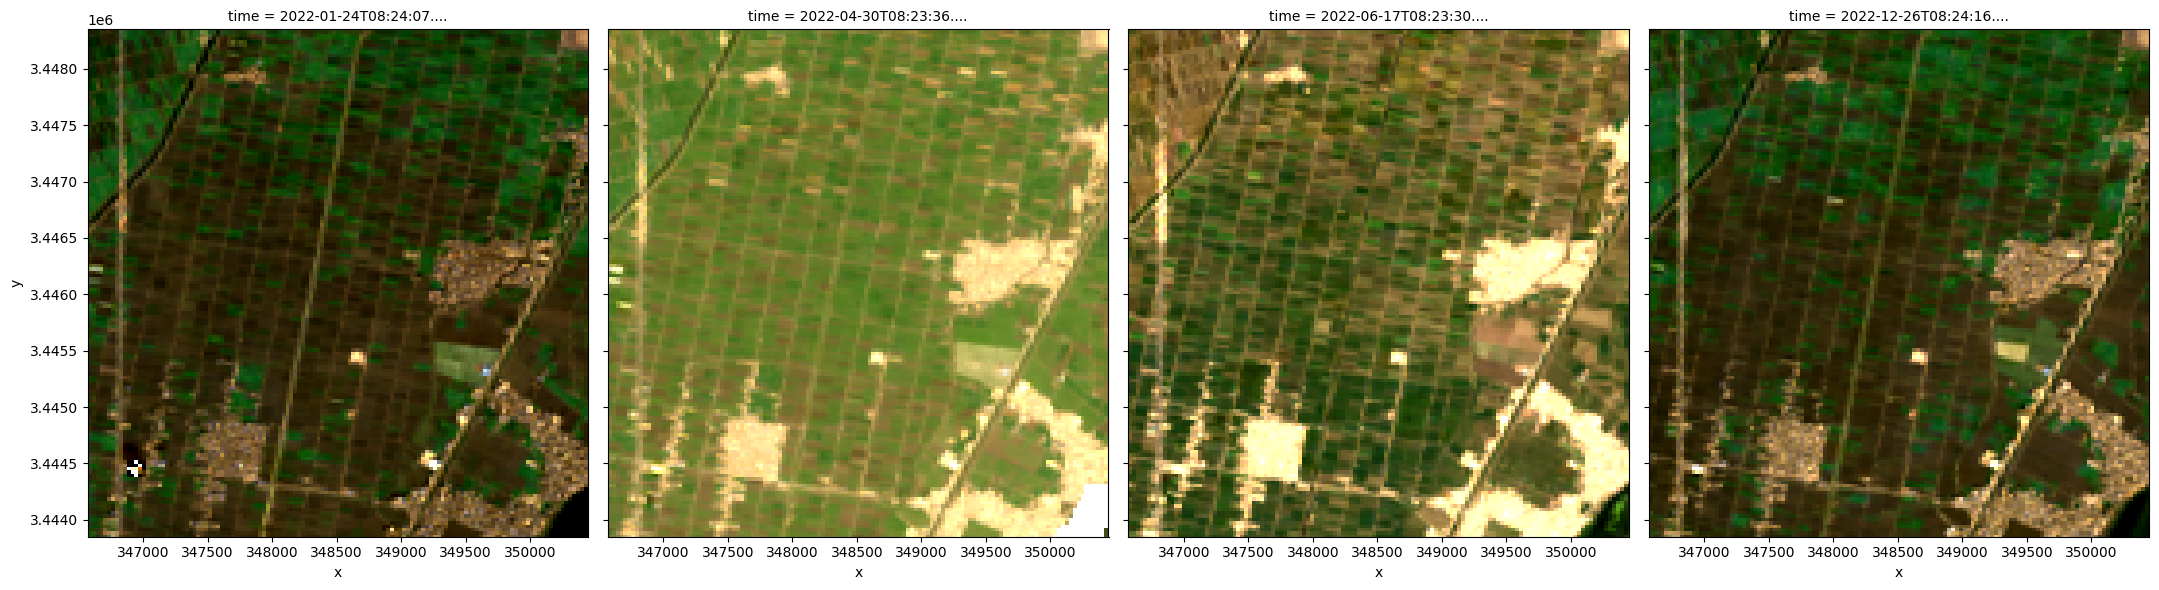

In [6]:
# Plot an RGB image
rgb(ds, index=[1, 10, 15, -1])

### Calculating the EVI using the calculate_indices function

The Enhanced Vegetation Index requires the red, nir and blue bands as well as an “L” value to adjust for canopy background, “C” values as coefficients for atmospheric resistance, and a gain factor (G).

The formula is

$$
\begin{aligned}
\text{EVI} & = G \times \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + C1 \times \text{Red} -C2 \times \text{Blue} + L)} \\
\end{aligned}
$$

The index is available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_tools.bandindices](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Tools/gen/deafrica_tools.bandindices.html).
Here,`satellite_mission='ls'` is used since we're working with Landsat 9.


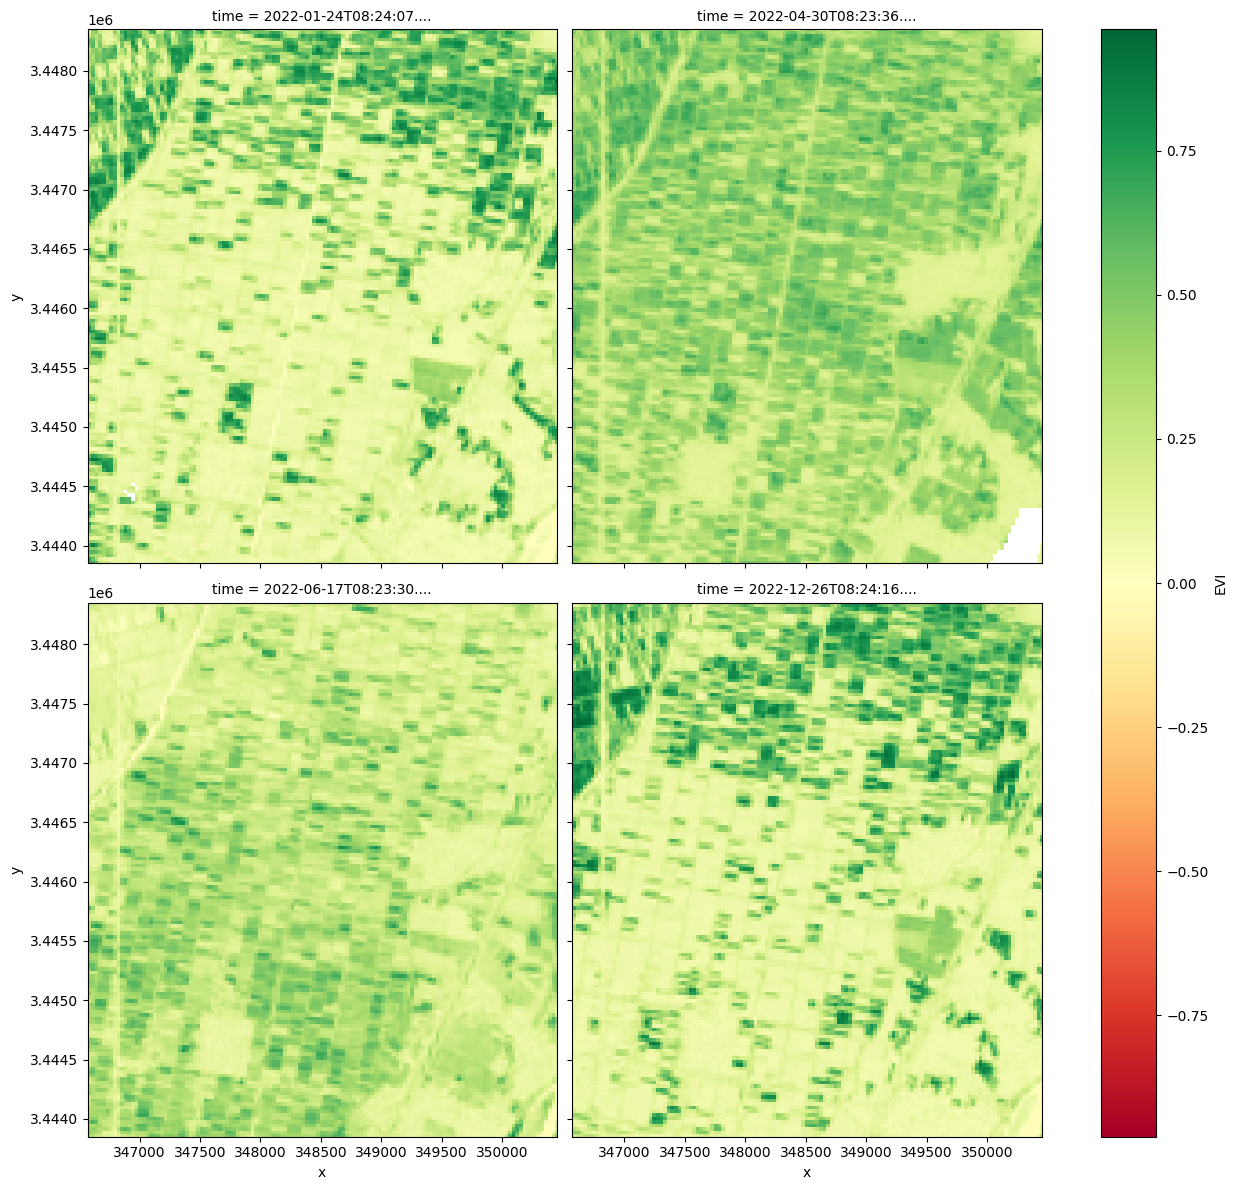

In [7]:
# Calculate EVI using `calculate indices`
ds = calculate_indices(ds, index='EVI', satellite_mission='ls')

#The vegetation proxy index should now appear as a data variable,
#along with the loaded measurements, in the `ds` object.

# Plot the selected EVI results at timestep 1, 10, 15 and last image
ds.isel(time=[1, 10, 15, -1]).EVI.plot(col='time',
                                       cmap='RdYlGn',
                                       size=6,
                                       col_wrap=2)

## Mask region with DE Africa's cropland extent map

Load the cropland mask over the region of interest.

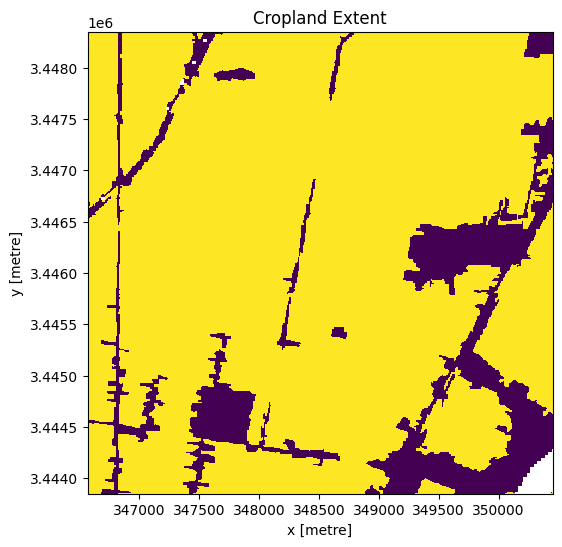

In [8]:
cm = dc.load(product='crop_mask',
             time=('2019'),
             measurements='filtered',
             resampling='nearest',
             like=ds.geobox).filtered.squeeze()

#Filter out the no-data pixels (255) and non-crop pixels (0) from the cropland map
cm.where(cm < 255).plot.imshow(
    add_colorbar=False,
    figsize=(6, 6))  # we filter to <255 to omit missing data
plt.title('Cropland Extent');

In [9]:
#mask only the cropland from the landsat 9 data.
ds = ds.where(cm == 1)

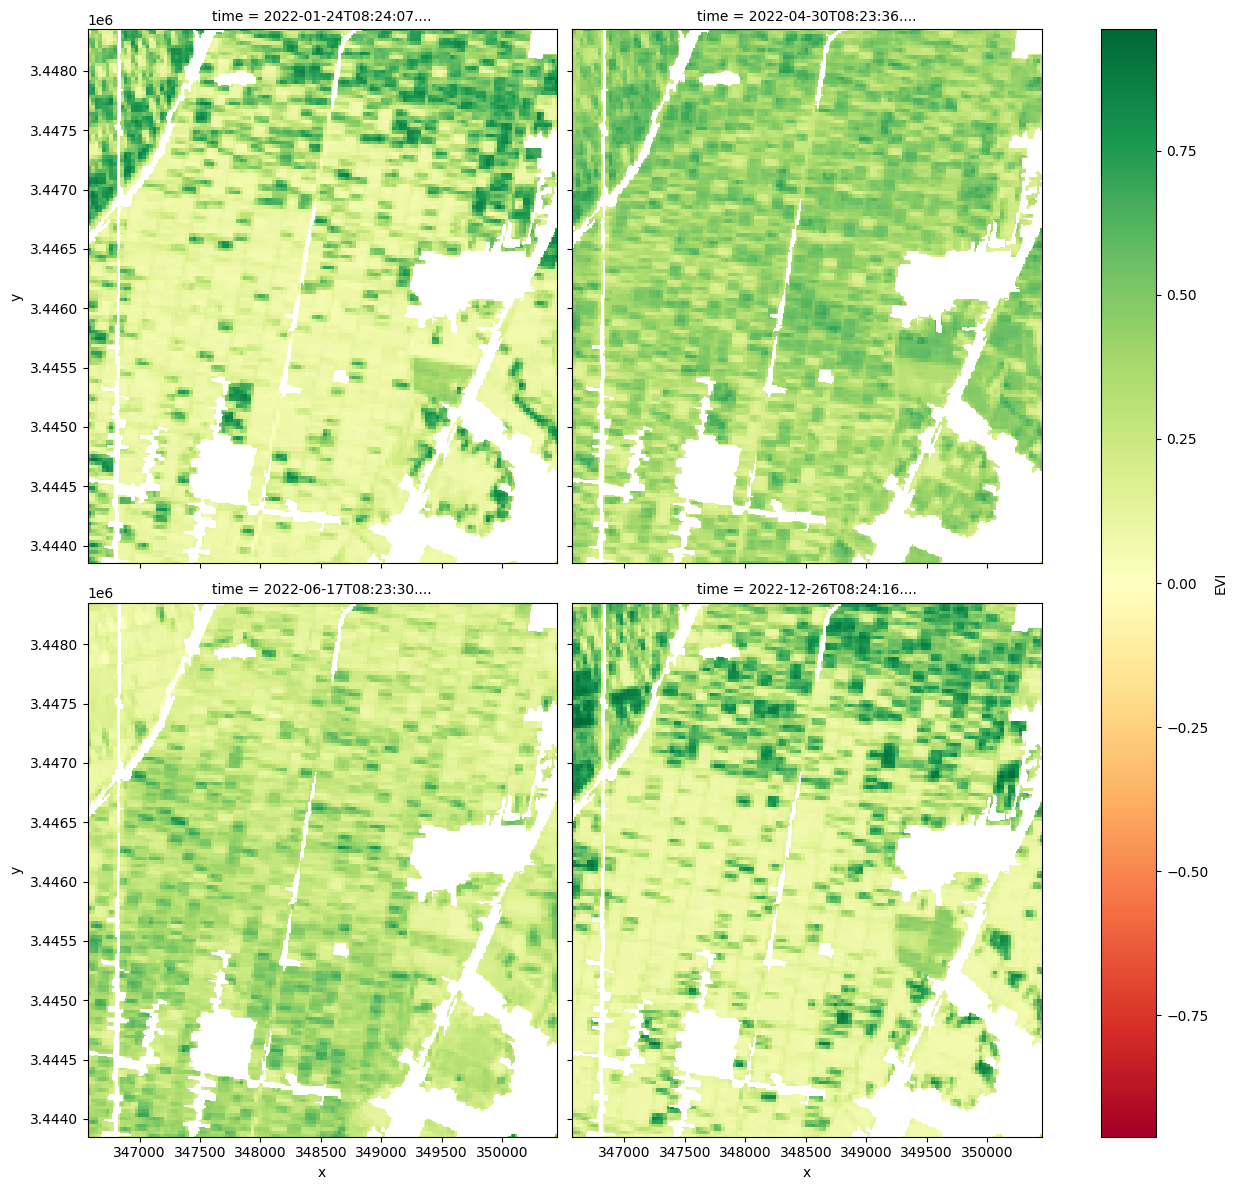

In [10]:
# Plot the selected EVI results with crops only at timestep 1, 10, 15 and last image
ds.isel(time=[1, 10, 15, -1]).EVI.plot(cmap='RdYlGn',
                                       col='time',
                                       size=6,
                                       col_wrap=2)

## Zonal mean of the EVI

To understand changes in vegetation health throughout the year(s), we plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  

The plot below shows two peaks, suggesting the area of interest is used for double cropping (growing two crops per year).

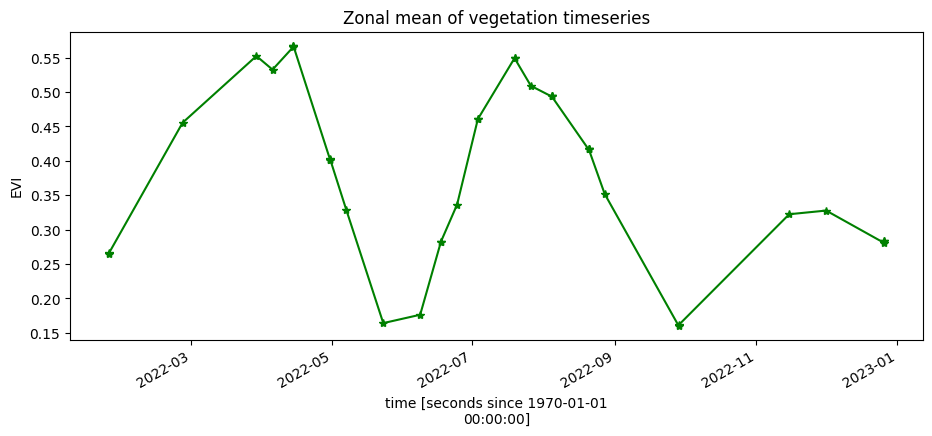

In [11]:
ds.EVI.mean(['x', 'y']).plot.line('g-*', figsize=(11, 4))
plt.title('Zonal mean of vegetation timeseries');

### Plot an individual image to view the spatial variations in EVI

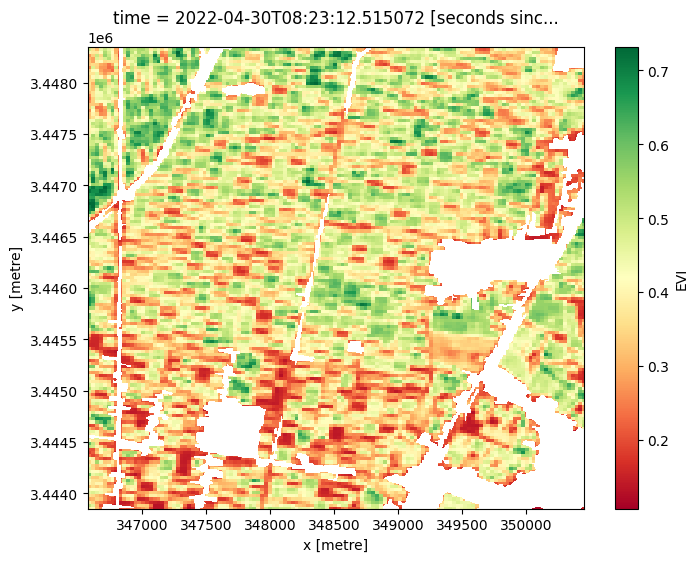

In [12]:
ds.isel(time=8).EVI.plot(cmap='RdYlGn', size=6, col_wrap=2)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [13]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [14]:
from datetime import date

print(date.today())

2023-08-14
